# Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Dataset Load-in

In [2]:
df = pd.read_csv("./DATA/wine_fraud.csv")

In [3]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,Legit,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,Legit,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,Legit,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,Legit,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,Legit,red


# Data Cleaning

In [4]:
df['type'] = pd.get_dummies(df['type'],drop_first=True)

In [5]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,Legit,False
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,Legit,False
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,Legit,False
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,Legit,False
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,Legit,False


In [6]:
df['quality'].value_counts()

quality
Legit    6251
Fraud     246
Name: count, dtype: int64

#### Sampling of Dataset using Random Sample Selection

In [7]:
df_legit = df[df['quality'] == 'Legit']
df_fraud = df[df['quality'] == 'Fraud']

df_legit_sampled = df_legit.sample(n=246, random_state=42)
df_balanced = pd.concat([df_legit_sampled, df_fraud], axis=0)
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Data Preprocessing

### Feature | Target Split

In [9]:
df_balanced['type'] = pd.get_dummies(df_balanced['type'],drop_first=True)

In [10]:
X = df_balanced.drop('quality',axis=1)
y = df_balanced['quality']

### Train | Test Split

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=101)

### Scaling

In [15]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

# ML Model 

In [26]:
from sklearn.svm import SVC

svc = SVC(class_weight='balanced', probability=True)

### GridSearch 

In [27]:
from sklearn.model_selection import GridSearchCV

param_grid = {'C':[0.001,0.01,0.1,0.5,1],'gamma':['scale','auto']}
grid = GridSearchCV(svc,param_grid)

grid.fit(scaled_X_train,y_train)

GridSearchCV(estimator=SVC(class_weight='balanced', probability=True),
             param_grid={'C': [0.001, 0.01, 0.1, 0.5, 1],
                         'gamma': ['scale', 'auto']})

In [28]:
grid.best_params_

{'C': 1, 'gamma': 'auto'}

# Model Evaluation 

In [29]:
from sklearn.metrics import confusion_matrix,classification_report

In [30]:
grid_pred = grid.predict(scaled_X_test)
confusion_matrix(y_test,grid_pred)

array([[17,  8],
       [ 7, 18]], dtype=int64)

In [31]:
print(classification_report(y_test,grid_pred))

              precision    recall  f1-score   support

       Fraud       0.71      0.68      0.69        25
       Legit       0.69      0.72      0.71        25

    accuracy                           0.70        50
   macro avg       0.70      0.70      0.70        50
weighted avg       0.70      0.70      0.70        50



# Model Saving as .pkl File

In [32]:
import pickle

with open('./Models/winefraud.pkl', 'wb') as file:
    pickle.dump(grid, file)

# Model Explainability with SHAP 

In [36]:
import shap

f = lambda x: grid.predict_proba(x)[:, 1]

explainer = shap.KernelExplainer(f, scaled_X_train, feature_names=X.columns)

Using 442 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [37]:
shap_values = explainer.shap_values(scaled_X_test)

  0%|          | 0/50 [00:00<?, ?it/s]

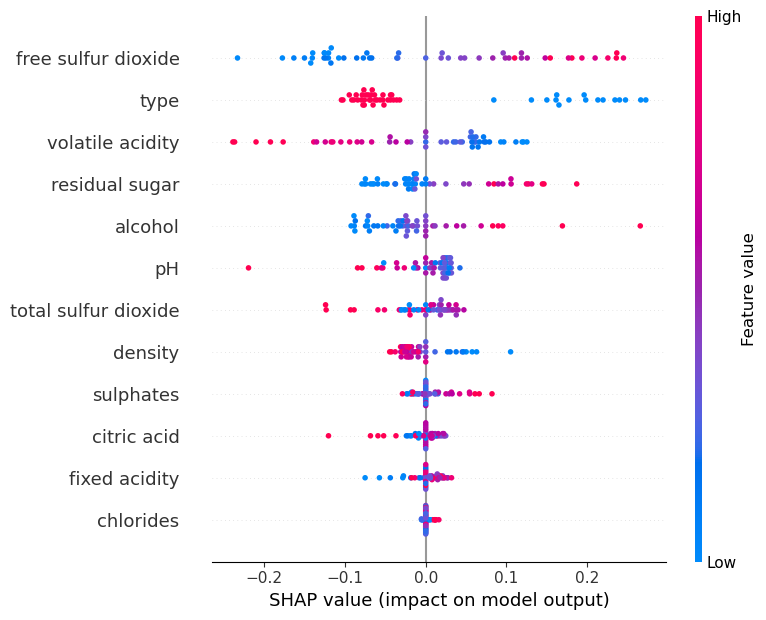

In [ ]:
shap.summary_plot(shap_values, scaled_X_test, feature_names=X.columns)